## Задача:

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  

## 1. Подготовка данных

In [1]:
import os
#os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *
from functions import *
import cv2
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

Посмотрим на данные:

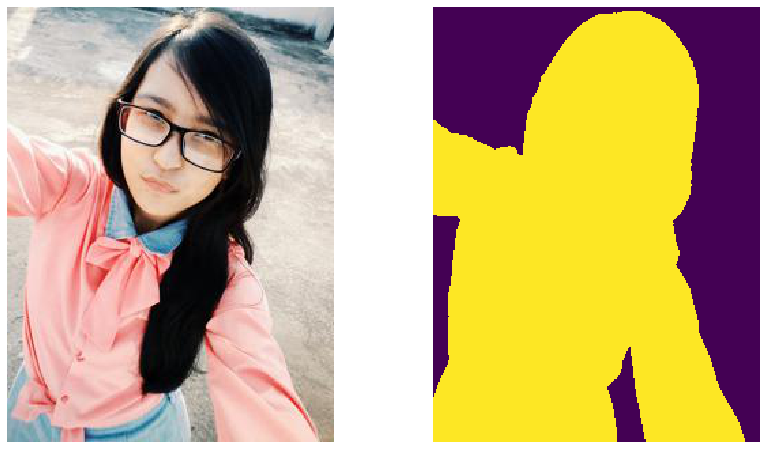

In [2]:
path = 'data/train'
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

In [3]:
img.shape



(320, 240, 3)

Каждое изображение хранится как массив размера $(320 \times 240 \times 3)$.

In [4]:
# создаем тренировочный и валидационный датасеты
train_df = create_dataset('data/train')
val_df = create_dataset('data/valid')

В датасете каждая строка соответсвует имени изображения и кода его маски:



In [5]:
train_df.head()


,0,1
0,348.jpg,7107 3 7345 5 7353 3 7359 6 7370 2 7584 8 7593...
1,1186.jpg,9231 19 9469 26 9707 34 9946 37 10184 41 10422...
2,412.jpg,4663 9 4901 15 5140 18 5379 21 5617 24 5857 25...
3,374.jpg,38315 6 38552 11 38789 16 38810 1 39023 2 3902...
4,360.jpg,1536 2 1550 2 1776 1 1778 21 2013 27 2250 32 2...


In [6]:
train_df.shape #1315 images

(1315, 2)

Чтобы не загружать все изображения в оперативную память во время обучения модели, создаем генератор, который будет формировать батчи "налету".

In [7]:
# пример на 16 элементов

for a,b in generator(train_df, 16):
    break

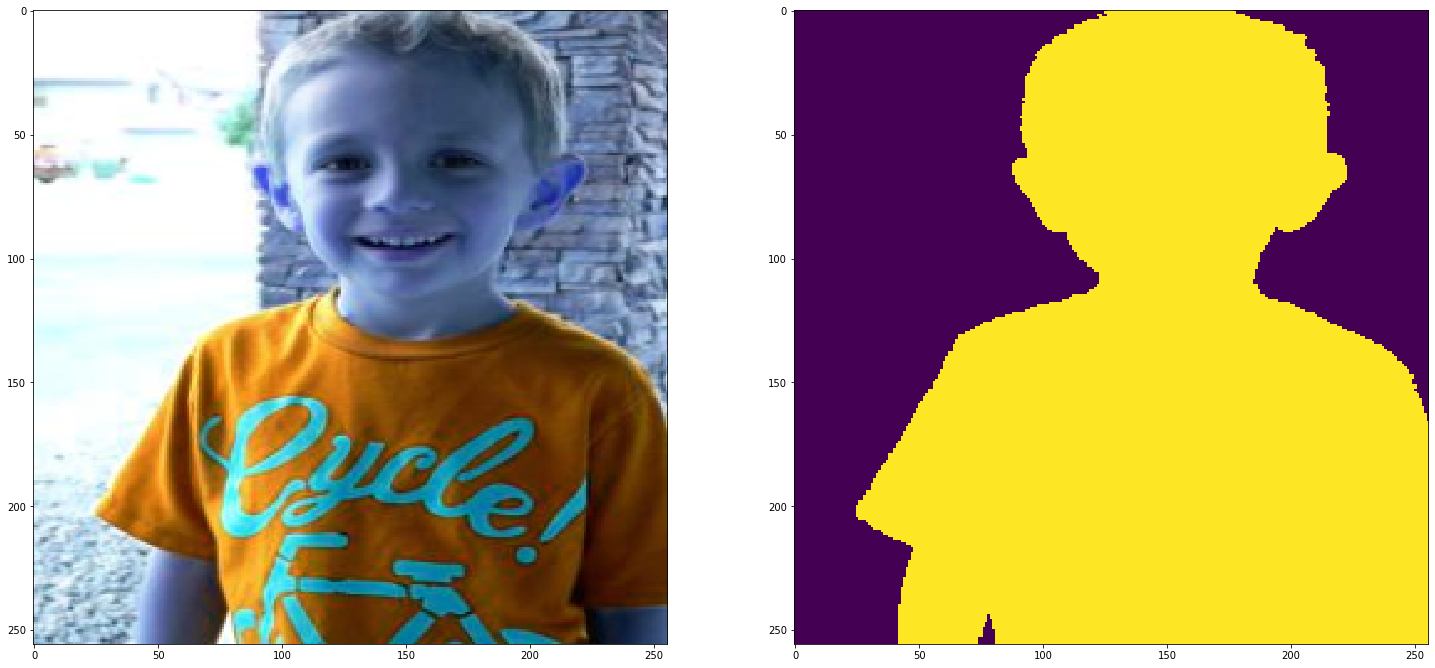

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(a[0])
axes[1].imshow(b[0][...,0])

plt.show()

## 2. Выбор и создание модели:

**Сегментация** - это процесс разделения изображения на несколько сегментов. 
Так как в данной задаче требуется сегментировать один объект, следовательно, всем пикселям требуется присвоить одну из двух меток.

Изображение в данной задаче хранится в виде тензора размера $320\times240\times3 (3$ канала цвета). Каким образом нужно оперировать с пикселями, чтобы получить правильно разделение фотографии? Чтобы решить, какую метку присвоить тому или иному пикселю, очевидно, нужно иметь информацию о его соседях. Как это можно сделать? Ответ: использовать **сверточную нейронную сеть**.
(Обычную нейронную сеть нет смысла использовать, ведь если весь тензор вытянуть в один вектор, пропадет большое количество нужной информации).



Используется нейронная сеть архитектуры [U-net](https://arxiv.org/pdf/1505.04597.pdf).

Основная идея архитекторы: конкатенировать тензоры одинакового размера, полученные после Maxpooling к с тензорами после Upsampling. Почему это хорошо работает? Соединения первые фич-мапы (полученные после сверток и Maxpooling) с последними позволяет лучше сегментировать изображение: из первых более пикселизированных фичей сетка получает информацию о границе человека на изображении , а из последних размытых о том, где в общем на изображении находится человек. 

In [9]:
import keras

model = create_model() # создаем модель

# сохраняем лучшие и последние веса модели за эпоху


best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',monitor='val_loss',verbose=0,
                                                                    save_best_only=True,
                                                                    save_weights_only=True)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',monitor='val_loss',verbose=0,
                                                                    save_best_only=False,
                                                                    save_weights_only=True)


callbacks = [best_w, last_w]

# компилируем модель 

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 3. Обучение:

In [10]:

batch_size = 16
model.fit_generator(generator(train_df, batch_size),
              steps_per_epoch = 50,
              epochs= 20,
              verbose=1,
              callbacks=callbacks,
              validation_data=generator_val(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)


Epoch 1/20
50/50 [==============================] - 767s 15s/step - loss: 0.6031 - val_loss: 0.4848
Epoch 2/20
50/50 [==============================] - 762s 15s/step - loss: 0.4959 - val_loss: 0.4814
Epoch 3/20
50/50 [==============================] - 1157s 23s/step - loss: 0.4477 - val_loss: 0.4162
Epoch 4/20
50/50 [==============================] - 730s 15s/step - loss: 0.4221 - val_loss: 0.3970
Epoch 5/20
50/50 [==============================] - 1211s 24s/step - loss: 0.3995 - val_loss: 0.4550
Epoch 6/20
50/50 [==============================] - 716s 14s/step - loss: 0.4051 - val_loss: 0.3752
Epoch 7/20
50/50 [==============================] - 739s 15s/step - loss: 0.4064 - val_loss: 0.4301
Epoch 8/20
50/50 [==============================] - 728s 15s/step - loss: 0.3800 - val_loss: 0.3812
Epoch 9/20
50/50 [==============================] - 731s 15s/step - loss: 0.3754 - val_loss: 0.4058
Epoch 10/20
50/50 [==============================] - 740s 15s/step - loss: 0.3693 - val_loss: 0.3

KeyboardInterrupt: 

Я остановила процесс обучения, потому что прошло много времени, а значение функции потерь не сильно менялось.

Посмотрим на предсказание модели на каком-нибудь одном элементе:

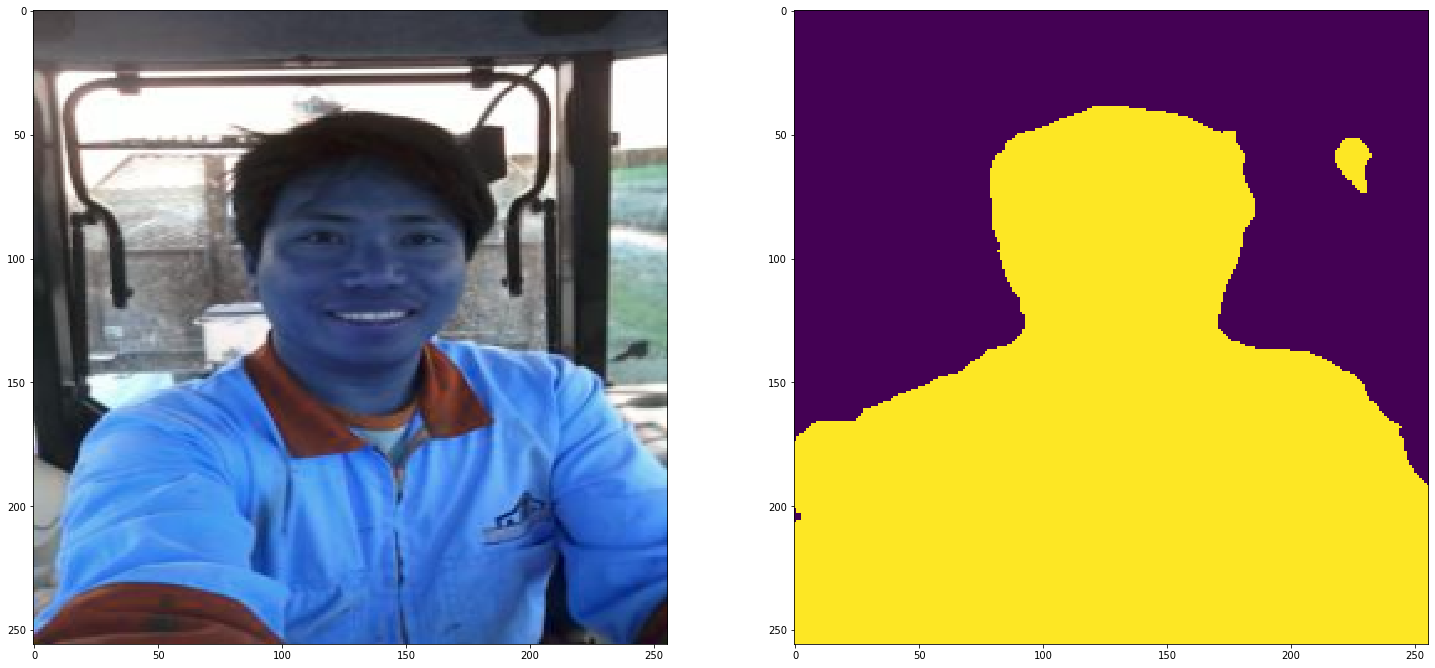

In [13]:
pred = model.predict(a)

im_id = 2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(a[im_id])
axes[1].imshow(pred[im_id,...,0]>0.5)

plt.show()

## 4. Результеты

Посчитаем значения метрики на валидационных данных:

In [14]:
from functions.valid import valid_mask_true

In [15]:
valid_true_mask = valid_mask_true()

Предскажем значения на валидационных данных и рассчитаем метрики:

In [16]:
arrays = []
names_valid = []
for i in val_df.sort_values(0).iloc[:,0].values:
    names_valid.append(i)
    img = cv2.imread('data/valid/'+i)
    img = cv2.resize(img, (256,256))
    arrays.append(img)
img = np.array(arrays)/ 255.
prediction = model.predict(img)

# все предсказания больше 0.5 интерпретируем как 1
# иначе 0,
# так как ответ модели - это массив из вероятностей ( от 0 до 1) принадлежности
# пикселей одному из двух классов

prediction_valid = prediction>0.5
prediction_valid = prediction_valid.astype(np.uint8)

Чтобы посчитать метрики, нужно изменить размер маски на (320,240):

In [17]:
from functions.valid import resize

prediction_valid = resize(prediction_valid[...,0])

In [18]:
get_dice(valid_true_mask, prediction_valid)

0.8836343821338474

Используемая метрика - бинарная мера сходства множества. Кажется, что результат довольно не плохой, ведь коэффицент близок к 1. Сложно судить о результате работы по одной цифре, поэтому посмотрим на предсказанные маски на тестовых данных.

## 5. Сохранение результатов

Создаём файл формата csv и сохраняем в него названия изображений из папки data/valid и rle коды их предсказанных маск:

In [19]:
zipp = zip(names_valid, map(lambda i: encode_rle(i), prediction_valid))
pred_valid_result = pd.DataFrame(zipp, columns = ['image', 'rle_mask'])

In [20]:
pred_valid_result.head()

,image,rle_mask
0,1315.jpg,170 9 410 9 650 7 890 7 1130 7 1369 7 1608 8 1...
1,1316.jpg,7789 15 8029 15 8265 22 8503 26 8742 30 8779 1...
2,1317.jpg,10680 9 10919 15 11131 4 11158 19 11362 15 113...
3,1318.jpg,6147 6 6385 18 6407 4 6623 32 6863 32 7100 36 ...
4,1319.jpg,11142 3 11382 4 11622 4 11862 3 13000 1 13238 ...


In [21]:
pred_valid_result.to_csv('data/pred_valid_template.csv')

Теперь работаем с тестовыми данными:

In [22]:
# Предсказываем на тестовых данных:
arrays = []
names = []
for i in sorted(os.listdir('data/test')):
    names.append(i)
    img = cv2.imread('data/test/'+i)
    img = cv2.resize(img, (256,256))
    arrays.append(img)
img = np.array(arrays)/ 255.
prediction = model.predict(img)
# все предсказания больше 0.5 интерпретируем как 1
# иначе 0,
# так как ответ модели - это массив из вероятностей ( от 0 до 1) принадлежности
# пикселей одному из двух классов
    
prediction = prediction>0.5
prediction = prediction.astype(np.uint8)*255

In [23]:
prediction[1,...,0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Теперь сохраняем получившиеся маски в папку data/test_mask:

In [24]:
from functions import make_dir


In [26]:
os.mkdir('data/test_mask')
make_dir(prediction, names)

Создаем html страницу с изображениями из data/test и их масками из data/test_mask:

In [27]:
paths_to_imgs = sorted(glob("data/test/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/test_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/result")

## 6. Выводы:

1) Обучение нейронной сети заняло большое количество времени. К сожалению, я не смогла решить эту проблему в связи с недостатком опыта в данной сфере. 


2) Результат работы довольно не точен (видно по изображению, сопоставленному с маской). Мне кажется, во-первых, проблема в небольшом количестве данных, во-вторых, думаю, если бы я перед обучение поработала бы над изображениями (сделала, к примеру, более констрастными), то это помогло бы сетке определять границы изображения человека на фотографии.


3) Сетка хорошо работает, если данные простые (человек на одноцветном фоне), но довольно плохо с необычными фотографиями, вероятно потому, что мало примеров таких изображений.

4) Возможно если бы сетка обучалась дольше, то результат был бы лучше.


In [ ]:
4)